In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import cv2
import pickle

# Step 1: Load all the models

### 1. Haar cascasde model for frontal face detection
### 2. PCA model that contains mean face and pca in the dictionary form
### 3. SVM model


In [2]:
haar = cv2.CascadeClassifier('./Pri_model/haarcascade_frontalface_default.xml')

In [3]:
svm_model = pickle.load(open('./saved_data/gender_classification_model_svm.pickle', mode = 'rb'))

In [14]:
pca_model = pickle.load(open('./model/pca_dict.pickle',mode='rb')) # pca dictionary

In [15]:
#extracting pca and mean face array from dictionary
model_pca = pca_model['pca']
mean_face_arr = pca_model['mean_face']

# Step 2: Creating a pipeline
## 



In [16]:
# 01: read image
image = cv2.imread('./Test_img_pri/img5.jpg') # BGR

# 02: convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 03:crop face using haar cascade classifier model

faces = haar.detectMultiScale(gray, 1.5, 3)  #providing - (image, scale-factor, min neighbor)

for x,y,w,h in faces:
    #cv2.rectangle(img_rgb, (x,y), (x+w, y+h), (0, 255, 0), 20)
    roi = gray[y:y+h, x:x+h]
    
    # 04:Normalization of cropped images [compressing the image value between 0,1]
    roi = roi/255.0
    
    # 05:Resize the image

    size = roi.shape[0]
    if size >= 100:
            # cv2.INTER_AREA (SHINK)
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
    else:
            # cv2.INTER_CUBIC (ENLARGE)
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC) 
            
    # 06:Flattening the image (1x10000)
    flatten_roi = roi_resize.reshape(1,10000)
    
    # 07: subtracting mean face from roi
    roi_mean = flatten_roi - mean_face_arr

    #08: extract eigen_faces: apply roi_mean to pca
    eigen_img = model_pca.transform(roi_mean)
    
    #09: eigen image
    ei_img = model_pca.inverse_transform(eigen_img)
    
    #10: pass eigen image to machine learning model(svm)
    model_predict = svm_model.predict(eigen_img)
    probability_score = svm_model.predict_proba(eigen_img)
    score_max = probability_score.max()
    
    
    #11: generate report
    text = "%s : %d"%(model_predict[0], score_max*100)
    
    #colour coding faces based on gender
    if model_predict[0] == 'male':
        color = (255, 0, 255)
    else:
        color = (0, 255, 255)

        cv2.rectangle(image, (x,y), (x+w, y+h), color, 2)
        cv2.rectangle(image, (x,y-40), (x+w, y), color, -1)
        cv2.putText(image,text, (x,y), cv2.FONT_HERSHEY_SIMPLEX,3, (255, 255, 255), 5)
        
    



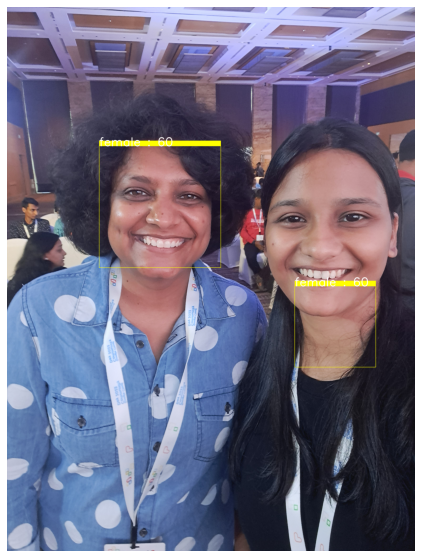

In [17]:
img_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()
